# This Notebook is done on kaggle

## Load data from hugging face

In [33]:
from datasets import load_dataset

train_data = load_dataset("food101", split="train[:10000]")

val_data = load_dataset("food101", split="validation[:3000]")


In [34]:
train_data

Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})

In [35]:
val_data


Dataset({
    features: ['image', 'label'],
    num_rows: 3000
})

In [36]:
split = val_data.train_test_split(0.5)

In [37]:
split

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1500
    })
})

In [38]:
val_data = split['train']

In [39]:
val_data

Dataset({
    features: ['image', 'label'],
    num_rows: 1500
})

In [40]:
test_data = split['test']

In [41]:
test_data

Dataset({
    features: ['image', 'label'],
    num_rows: 1500
})

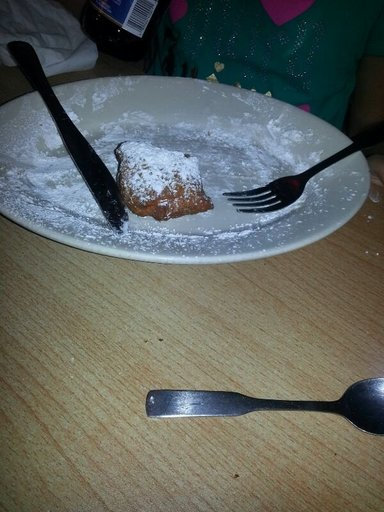

In [42]:
train_data[0]["image"]


In [43]:
labels = train_data.features["label"].names
labels

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [44]:
label2id, id2label = {}, {}
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[0], label2id["apple_pie"]


('apple_pie', 0)

## Loading Preprocess of DINOv2

In [45]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

processor

BitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}

In [46]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

test_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_test(example_batch):
    example_batch['pixel_values'] = [val_transforms(image.convert("RGB")) for image in example_batch['image']]
    return example_batch

In [47]:
train_data.set_transform(preprocess_train)
val_data.set_transform(preprocess_val)
test_data.set_transform(preprocess_test)

In [48]:
train_data[0]

{'image': <PIL.Image.Image image mode=RGB size=384x512>,
 'label': 6,
 'pixel_values': tensor([[[-1.6042, -1.4500, -1.3644,  ..., -1.7754, -1.7583, -1.7583],
          [-1.7583, -1.5870, -1.3987,  ..., -1.7754, -1.7754, -1.7754],
          [-1.7925, -1.7412, -1.6213,  ..., -1.7925, -1.7925, -1.7754],
          ...,
          [-0.6281, -0.6109, -0.5767,  ..., -2.0152, -2.0665, -2.0665],
          [-0.7822, -0.7650, -0.7137,  ..., -1.9980, -2.0494, -2.0665],
          [-0.6794, -0.6452, -0.7993,  ..., -1.9809, -2.0323, -2.0665]],
 
         [[-1.4930, -1.3004, -1.1954,  ..., -1.6331, -1.6331, -1.6155],
          [-1.6331, -1.4580, -1.2479,  ..., -1.6331, -1.6331, -1.6331],
          [-1.6681, -1.6155, -1.5105,  ..., -1.6506, -1.6506, -1.6681],
          ...,
          [-0.7052, -0.6702, -0.6001,  ..., -1.8256, -1.8431, -1.8431],
          [-0.8277, -0.7927, -0.7227,  ..., -1.8256, -1.8606, -1.8431],
          [-0.7052, -0.6352, -0.7927,  ..., -1.8256, -1.8606, -1.8782]],
 
         [[-1.

In [49]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    'facebook/dinov2-base',
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
model_name = 'dinov2-Base'
batch_size = 4

In [51]:
import transformers
print(transformers.__version__)

4.51.3


In [52]:
import accelerate
print(accelerate.__version__)

1.5.2


In [53]:
import torch
from accelerate import Accelerator

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU")

# Use accelerate to get device info
accelerator = Accelerator()
print("Accelerator device:", accelerator.device)

CUDA available: True
GPU: Tesla P100-PCIE-16GB
Accelerator device: cuda


In [54]:
from transformers import TrainingArguments

args = TrainingArguments(
    f"{model_name}-finetuned-food101",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    report_to="none",
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    disable_tqdm=False
)

In [27]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn

In [55]:
import evaluate

# Load the accuracy and F1 metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

In [56]:
import numpy as np
def compute_metrics(eval_pred):
    """Computes accuracy, F1 score, and confusion matrix on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    references = eval_pred.label_ids

    # Compute accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=references)['accuracy']

    # Compute F1 score
    f1 = f1_metric.compute(predictions=predictions, references=references, average="weighted")['f1']


    return {
        "accuracy": accuracy,
        "f1": f1,
    }

In [57]:
#is used to combine pixel values and their corresponding labels into a batch of data ready for training.
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values'] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {'pixel_values':pixel_values,'labels':labels}

In [58]:
from transformers import Trainer

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

/tmp/ipykernel_35/2417865765.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [59]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.675000,0.177775,0.938000,0.939862
2,0.528400,0.124790,0.961333,0.961474
3,0.345500,0.154819,0.951333,0.952255
4,0.191500,0.132088,0.956667,0.958642
5,0.195300,0.077151,0.978000,0.978435
6,0.183000,0.082861,0.977333,0.978127
7,0.151300,0.113353,0.972000,0.973511
8,0.122200,0.116368,0.972000,0.972865
9,0.200100,0.086529,0.977333,0.978270
10,0.061800,0.092357,0.980000,0.980943


In [60]:
trainer.save_model()
trainer.log_metrics("train", train_result.metrics)
trainer.save_metrics("train", train_result.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         10.0
  total_flos               = 9529070471GF
  train_loss               =       0.2806
  train_runtime            =   1:14:33.25
  train_samples_per_second =       22.355
  train_steps_per_second   =        1.397


In [61]:
metrics = trainer.evaluate()
trainer.log_metrics('eval',metrics)
trainer.save_metrics("eval",metrics)

***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =       0.98
  eval_f1                 =     0.9809
  eval_loss               =     0.0924
  eval_runtime            = 0:00:25.78
  eval_samples_per_second =     58.179
  eval_steps_per_second   =     14.545


In [62]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.08449425548315048, 'test_accuracy': 0.9786666666666667, 'test_f1': 0.9785744162673771, 'test_runtime': 25.8821, 'test_samples_per_second': 57.955, 'test_steps_per_second': 14.489}


In [63]:
torch.save(model.state_dict(), f='custom_weights.pt')

In [64]:
from huggingface_hub import notebook_login
notebook_login()

In [65]:
trainer.push_to_hub('DINOv2-finetuned-on-food101')

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Haaaaaaaaaax/dinov2-Base-finetuned-food101/commit/b6415b88b6a4a76beddc822fe23aed64cc6c28c2', commit_message='DINOv2-finetuned-on-food101', commit_description='', oid='b6415b88b6a4a76beddc822fe23aed64cc6c28c2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Haaaaaaaaaax/dinov2-Base-finetuned-food101', endpoint='https://huggingface.co', repo_type='model', repo_id='Haaaaaaaaaax/dinov2-Base-finetuned-food101'), pr_revision=None, pr_num=None)

In [69]:
len(label2id)

101

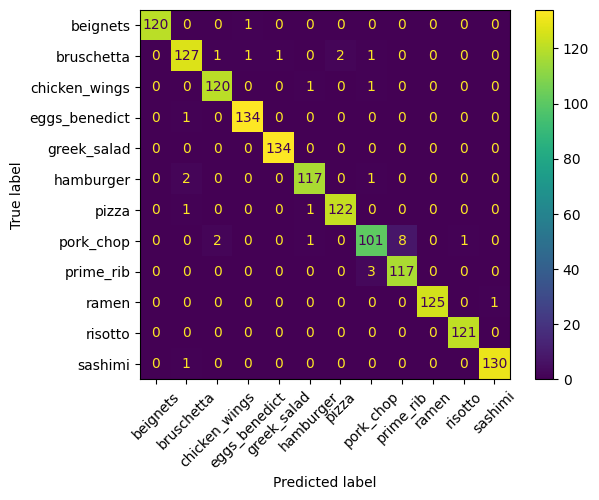

In [73]:
# we can't print the confusion matrix for 101 classes so i took a sample

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# Get unique class indices that appear in the data
present_labels = np.unique(np.concatenate([y_true, y_pred]))

# Select only those label names
label_names = [train_data.features['label'].names[i] for i in present_labels]

# Compute CM limited to present labels
cm = confusion_matrix(y_true, y_pred, labels=present_labels)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation=45)


In [74]:
from sklearn.metrics import recall_score

recall = recall_score(y_true,y_pred,average=None)
for label,score in zip(labels,recall):
    print(f"Recall for {label}: {score:.2f}")

Recall for apple_pie: 0.99
Recall for baby_back_ribs: 0.95
Recall for baklava: 0.98
Recall for beef_carpaccio: 0.99
Recall for beef_tartare: 1.00
Recall for beet_salad: 0.97
Recall for beignets: 0.98
Recall for bibimbap: 0.89
Recall for bread_pudding: 0.97
Recall for breakfast_burrito: 0.99
Recall for bruschetta: 1.00
Recall for caesar_salad: 0.99


In [75]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix


# Calculate precision and recall for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

# Calculate specificity for each class
specificities = []
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
for i, label in enumerate(labels):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificities.append(specificity)

# Calculate overall metrics
overall_precision = precision_score(y_true, y_pred, average='weighted')
overall_recall = recall_score(y_true, y_pred, average='weighted')
overall_specificity = np.mean(specificities)  # Average specificity across all classes

# Print overall metrics
print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall Recall: {overall_recall:.2f}")
print(f"Overall Specificity: {overall_specificity:.2f}")
print("************************************************************************************")

# Print precision, recall, and specificity for each label
for label, prec, rec, spec in zip(labels, precision, recall, specificities):
    print(f"Class '{label}': Precision = {prec:.2f}, Recall = {rec:.2f}, Specificity = {spec:.2f}")


Overall Precision: 0.98
Overall Recall: 0.98
Overall Specificity: 1.00
************************************************************************************
Class 'apple_pie': Precision = 1.00, Recall = 0.99, Specificity = 1.00
Class 'baby_back_ribs': Precision = 0.96, Recall = 0.95, Specificity = 1.00
Class 'baklava': Precision = 0.98, Recall = 0.98, Specificity = 1.00
Class 'beef_carpaccio': Precision = 0.99, Recall = 0.99, Specificity = 1.00
Class 'beef_tartare': Precision = 0.99, Recall = 1.00, Specificity = 1.00
Class 'beet_salad': Precision = 0.97, Recall = 0.97, Specificity = 1.00
Class 'beignets': Precision = 0.98, Recall = 0.98, Specificity = 1.00
Class 'bibimbap': Precision = 0.94, Recall = 0.89, Specificity = 1.00
Class 'bread_pudding': Precision = 0.94, Recall = 0.97, Specificity = 1.00
Class 'breakfast_burrito': Precision = 1.00, Recall = 0.99, Specificity = 1.00
Class 'bruschetta': Precision = 0.99, Recall = 1.00, Specificity = 1.00
Class 'caesar_salad': Precision = 0.99, 

## Inference

In [80]:
test_data

Dataset({
    features: ['image', 'label'],
    num_rows: 1500
})

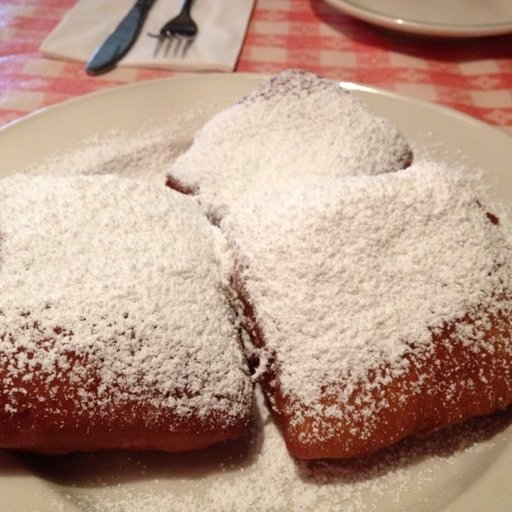

In [81]:
test_data[100]['image']

In [83]:
test_data[100]['label']

6

In [84]:
id2label[test_data[100]['label']]

'beignets'

In [82]:
# Load model directly
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("Haaaaaaaaaax/dinov2-Base-finetuned-food101")
model = AutoModelForImageClassification.from_pretrained("Haaaaaaaaaax/dinov2-Base-finetuned-food101")
# Load an image

image = test_data[100]['image']

# Preprocess the image
inputs = processor(images=image, return_tensors="pt") # return pythorch tensor

# Perform inference
with torch.no_grad(): #stop training
    outputs = model(**inputs)

# Get the predicted label
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predicted_class = predictions.argmax().item()

# Map the predicted class index to a label
labels = model.config.id2label
predicted_label = labels[predicted_class]

print(f"Predicted label: {predicted_label}")


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.79k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Predicted label: beignets


## True prediction